In [1]:
import cv2
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np
import os
import pandas as pd
import random
import re



# Import PyTorch
import torch
import torch.nn as tnn
import torch.nn.functional as tnf
import torch.optim as top
import torchvision
import torchvision.transforms as tvt
from torch.utils.data import TensorDataset, DataLoader, Dataset

from PIL import Image

import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score

# Background

The aim is to identify metastatic cancer from images from pathology scans. This is a particularly difficult problem as not only are the dimensions of the images small (96x96 px) but also the metastasized cells can be quite small.

There are over 250,000 RGB images available in the data, with ~ 220 thousand being used for training. Kaggle states that while the data is part of the PCam dataset, all duplicate images have been removed. A positive detection means cancer was detected anywhere in the **center** 32x32 patch of the image which means all pixels outside of this 32x32 area can be ignored as they're not relevant to the detection.

# EDA

In [2]:
root = os.environ['HOME'] + "/Scripts/histopathologic-cancer-detection"

In [3]:
labels = pd.read_csv(f"{root}/train_labels.csv")
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


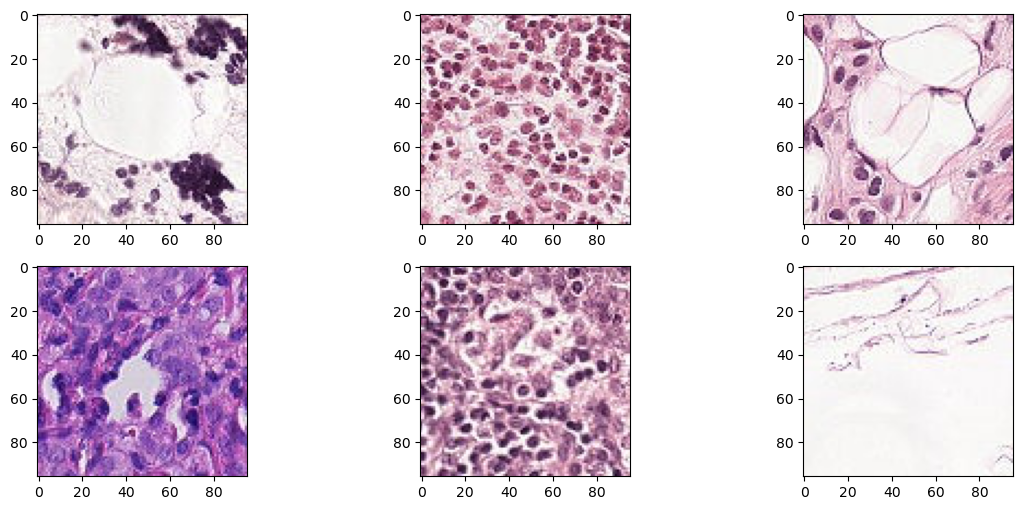

In [4]:
fig, ax = plt.subplots(2, 3, figsize=(14, 6))

for i in range(3):
    img1 = f"{f'{root}/train'}/{os.listdir(f'{root}/train')[random.randint(0, 100)]}"
    img2 = f"{f'{root}/test'}/{os.listdir(f'{root}/test')[random.randint(0, 100)]}"
    
    ax[0, i].imshow(mpimg.imread(img1))
    ax[1, i].imshow(mpimg.imread(img2))

Since only the center 32x32 region is used for learning, cropping the images before training seems ideal. But it also risks cropping out information on the edges. Starting with half the original size seems like a good place to start as it's still bigger than the center region.

As there are over 220 thousand training images, sampling a section of it leaves extra training data to use for improvements.

In [5]:
df_pos = labels[labels['label'] == 1].sample(60000, random_state=42)
df_neg = labels[labels['label'] == 0].sample(60000, random_state=42)

train = pd.concat([df_pos, df_neg], axis=0).reset_index(drop=True)
train = sklearn.utils.shuffle(train)

train.head()

,id,label
49942,71d8a1987ac628c27cfdf1b3a51a98d71e7a949e,1
52897,e77ea351ee4eb860cd66d67a6409d0f60060f6c1,1
110713,db4834a8c61cbd2f465d38c53793db89c1216533,0
2692,05ce96e76de1558ada854e01ac6a0f5a926c04f6,1
66590,a14f3813a7a5266612d8073239953e0a96ecd5fa,0


In [56]:
test = pd.DataFrame(columns=['id', 'label'])
test['id'] = [_.replace('.tif', '') for _ in os.listdir(f"{root}/test") if _[0] != '.']
test = sklearn.utils.shuffle(test)

test.head()

,id,label
54929,256318f5ab3f06b6057c0b6323899df0d8cbb1da,NaN
27176,ddc47d8c66d43d688141cff9de85ce378113ecbc,NaN
24051,3a053234b649a1773e38e30a004271af0d14bea2,NaN
48165,46a500bcbf96ff4b1d6fbf61868f6b7569a9fd0e,NaN
28330,9b8dcb35d4deb5a81dd5d666219b908c737c9fbb,NaN


# Design and Training

In [58]:
class mapdata():
    def __init__(self, df, dtype, transforms):
        # super().__init__()
        self.id    = df['id'].to_list()
        self.label = df['label'].to_list()
        self.dtype = dtype
        self.trfrs = transforms
        return

    def __getitem__(self, i):
        img_id = self.id[i]
        image  = cv2.imread(f"{root}/{self.dtype}/{img_id}.tif")
        return self.trfrs(image), self.label[i]

    def __len__(self):
        return len(self.id)

In [59]:
trfs     = tvt.Compose([tvt.ToPILImage(), tvt.ToTensor(), tvt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_df = mapdata(df=train, dtype='train', transforms=trfs)
test_df  = mapdata(df=test, dtype='test', transforms=trfs)

In [60]:
## create validation set
train_idx = list(range(len(train_df)))
test_idx  = list(range(len(test_df)))

train_smp = train_idx[int(len(train_df) * 0.15):]
valid_smp = train_idx[:int(len(train_df) * 0.15)]

train_dl = torch.utils.data.DataLoader(train_df, batch_size=128, sampler=torch.utils.data.sampler.SubsetRandomSampler(train_smp))
valid_dl = torch.utils.data.DataLoader(train_df, batch_size=128, sampler=torch.utils.data.sampler.SubsetRandomSampler(valid_smp))
test_dl  = torch.utils.data.DataLoader(test_df, batch_size=128, sampler=torch.utils.data.sampler.SubsetRandomSampler(test_idx))

In [47]:
class CNN_model(tnn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        
        l1, l2, l3, l4 = 32, 64, 128, 256
        self.conv_l1 = tnn.Sequential(
            tnn.Conv2d(in_channels=3, out_channels=l1, kernel_size=3),
            tnn.BatchNorm2d(l1),
            tnn.ReLU(inplace=True),
            tnn.MaxPool2d(2, 2)
        )
        self.conv_l2 = tnn.Sequential(
            tnn.Conv2d(in_channels=l1, out_channels=l2, kernel_size=3, padding=2),
            tnn.BatchNorm2d(l2),
            tnn.ReLU(inplace=True),
            tnn.MaxPool2d(2, 2)
        )
        self.conv_l3 = tnn.Sequential(
            tnn.Conv2d(in_channels=l2, out_channels=l3, kernel_size=3, padding=2),
            tnn.BatchNorm2d(l3),
            tnn.ReLU(inplace=True),
            tnn.MaxPool2d(2, 2)
        )
        self.conv_l4 = tnn.Sequential(
            tnn.Conv2d(in_channels=l3, out_channels=l4, kernel_size=3, padding=2),
            tnn.BatchNorm2d(l4),
            tnn.ReLU(inplace=True),
            tnn.MaxPool2d(2, 2)
        )
        self.drop = tnn.Dropout2d
        self.dense_l5 = tnn.Sequential(
            tnn.Linear(12544, 512),
            tnn.ReLU(inplace=True),
            tnn.Dropout(0.3),
            tnn.Linear(512, 256),
            tnn.ReLU(inplace=True),
            tnn.Dropout(0.3),
            tnn.Linear(256, 1),
            tnn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_l4(self.conv_l3(self.conv_l2(self.conv_l1(x))))
        x = self.dense_l5(x.view(x.shape[0], -1))
        return x

In [48]:
def training(data, if_valid=False):

    data_loss = 0
    score = []
    for y_in, y_true in data:
        y_pred = model(y_in.to(gpu))
        y_loss = loss(y_pred, y_true.float().view(-1, 1).to(gpu))
        data_loss += y_loss.item() * y_in.shape[0]

        if not if_valid:
            y_loss.backward()
            error.step()
            error.zero_grad()
        else:
            y_pred = y_pred[:, -1].detach().cpu().numpy()
            y_true = y_true.data.cpu().numpy()
            score.append(roc_auc_score(y_true, y_pred))

    data_loss = data_loss / len(data.sampler)
    return data_loss, np.mean(score)

In [49]:
model = CNN_model()
loss  = tnn.BCELoss()

if torch.backends.mps.is_available():
    gpu   = torch.device("mps")
    model = model.to(gpu)

error = top.Adam(model.parameters(), lr = 0.0003)

In [12]:
train_loss, valid_loss, auc_scores = [], [], []
min_loss = np.Inf

for epoch in range(1, 11):
    model.train()
    tloss, _ = training(train_dl)

    model.eval()
    vloss, score = training(valid_dl, if_valid=True)
    
    train_loss.append(tloss)
    valid_loss.append(vloss)
    auc_scores.append(score)

    print(f"epoch: {epoch}")
    print(f"auc: {score}")
    print(f"train/valid loss: {tloss} | {vloss}\n")

    if vloss <= min_loss:
        min_loss = vloss

/Users/saravi/Software/miniforge3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saravi/Software/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


epoch: 1
auc: 0.9406669416316005
train/valid loss: 0.3743310858081369 | 0.3326803110970391



/Users/saravi/Software/miniforge3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saravi/Software/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


epoch: 2
auc: 0.9572117552686736
train/valid loss: 0.2952894071784674 | 0.28130351316928864



/Users/saravi/Software/miniforge3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saravi/Software/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


epoch: 3
auc: 0.9637998590559018
train/valid loss: 0.2501501836683236 | 0.2951337039205763



/Users/saravi/Software/miniforge3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saravi/Software/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


epoch: 4
auc: 0.9715218806253957
train/valid loss: 0.219656769787564 | 0.22895423793792724



/Users/saravi/Software/miniforge3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saravi/Software/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


epoch: 5
auc: 0.9691069887820736
train/valid loss: 0.1993519756747227 | 0.3423116505278481



/Users/saravi/Software/miniforge3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saravi/Software/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


epoch: 6
auc: 0.9767879938080077
train/valid loss: 0.18102229565498876 | 0.19692382241619957



/Users/saravi/Software/miniforge3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saravi/Software/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


epoch: 7
auc: 0.9813792771071265
train/valid loss: 0.16490399463445532 | 0.21095076535807716



/Users/saravi/Software/miniforge3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saravi/Software/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


epoch: 8
auc: 0.9825072164166971
train/valid loss: 0.15077869084185244 | 0.1673568880425559



/Users/saravi/Software/miniforge3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saravi/Software/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


epoch: 9
auc: 0.9788399245111092
train/valid loss: 0.13681241167877234 | 0.2793191314008501



/Users/saravi/Software/miniforge3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saravi/Software/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


epoch: 10
auc: 0.9849839924795996
train/valid loss: 0.12566337467993008 | 0.1541771020491918



# Results

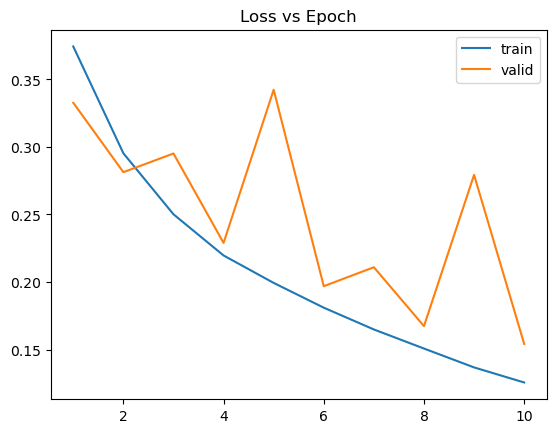

In [27]:
plt.plot(range(1, 11), train_loss, label='train')
plt.plot(range(1, 11), valid_loss, label='valid')
plt.title('Loss vs Epoch')
plt.legend()

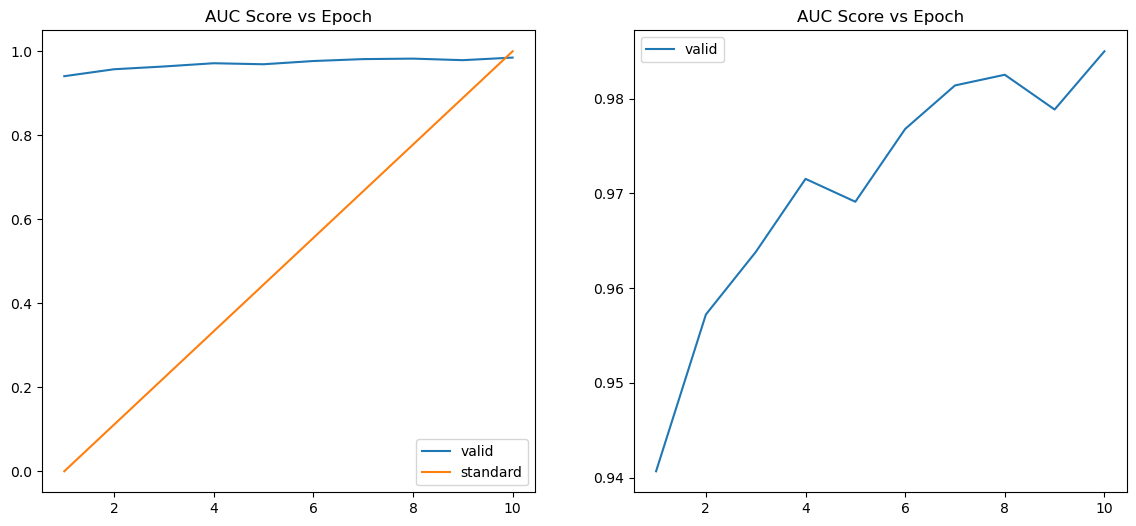

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(range(1, 11), auc_scores, label='valid')
ax[1].plot(range(1, 11), auc_scores, label='valid')
ax[0].plot(range(1, 11), np.linspace(0, 1, 10), label='standard')

ax[0].set_title('AUC Score vs Epoch')
ax[1].set_title('AUC Score vs Epoch')
ax[0].legend()
ax[1].legend()